# prerequisite

* language: Python3.7
* Python lib
    * scikit-learn-0.20.2
    * pandas-0.24.1
    * matplotlib-3.0.2

In [1]:
%matplotlib inline
import PIL.Image
import IPython.display
import numpy as np
from sklearn import datasets
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#helpler function
def showarray(a):
    a = np.uint8(a)
    IPython.display.display(PIL.Image.fromarray(a))

In [3]:
# TODO replace the sampled 8*8 digits dataset with full MNIST

## load dataset

In [4]:
data, label = datasets.load_digits(return_X_y=True)

In [5]:
instance, feature_num = data.shape
np.random.seed(2019)
randomize = np.random.permutation(instance)
data = data[randomize]
label = label[randomize]

In [6]:
print("%d instance with %d features" % (instance, feature_num))
print('data shape', data.shape)
print('label shape', label.shape)

1797 instance with 64 features
data shape (1797, 64)
label shape (1797,)


## check loaded data

In [7]:
debug_data = data.reshape((1797, 8, 8))

In [8]:
idx = 4
img = 256 - debug_data[idx]
l = label[idx]
print("label is %d" % l)
print("image is ")
showarray(img)

label is 6
image is 


## bandit algorithm with epsilon 0.5

In [9]:
def run_agent(epsilon, epochs):
    arms = list(range(0, 10))
    # arm -> ([feature0, feature1, ...], [0, 1, ...])
    train_set = {}

    # arm -> theta_array: np array
    theta_set = {}

    for arm in arms:
        train_set[arm] = ([], [])
        v = np.zeros(feature_num + 1)
        v[-1] = 0.5
        theta_set[arm] = v

    avg_actual_reward = []
    actual_reward_sum = 0
    trials = []
    idx = 0
    for epoch in range(epochs):
        for t in range(instance):
            append_feature = np.append(data[t], [1])
            pickup_arm = arms[0]
            if np.random.rand() < epsilon:
                # exploration
                pickup_arm = arms[np.random.randint(len(arms))]        
            else:
                # exploitation
                max_arm = [arms[0]] # the arm with same reward
                max_reward = -1 # possible min reward is 0
                for arm in arms:
                    expected_reward = theta_set[arm].dot(append_feature)            
                    if expected_reward > max_reward:
                        max_reward = expected_reward
                        max_arm = [arm]
                    elif expected_reward == max_reward:
                        max_arm.append(arm)
                pickup_arm = max_arm[np.random.randint(len(max_arm))]        

            actual_reward = int(pickup_arm == label[t])
            train_set[pickup_arm][0].append(append_feature)
            train_set[pickup_arm][1].append(actual_reward)

            trials.append(idx)
            actual_reward_sum += actual_reward
            avg_actual_reward.append( actual_reward_sum / len(trials))
            idx += 1
            # update theta_set[pickup_arm] since we observe new train instance
            if len(train_set[pickup_arm][1]) > 10:
                reg = linear_model.LinearRegression()
                reg.fit(train_set[pickup_arm][0], train_set[pickup_arm][1])
                theta_set[pickup_arm] = reg.coef_
    return trials, avg_actual_reward

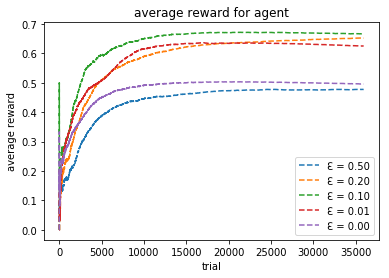

In [10]:
legends = []
fig, num_ax = plt.subplots(nrows=1, ncols=1)
for epsilon in [0.5, 0.2, 0.1, 0.01, 0]:
    trials_agent, avg_actual_reward_agent = run_agent(epsilon, epochs=20)
    line = num_ax.plot(trials_agent, avg_actual_reward_agent, '--')
    legends.append("ℇ = %.2f" % epsilon)
num_ax.set(title="average reward for agent", xlabel="trial", ylabel="average reward")   
num_ax.legend(legends, loc='lower right')
fig.savefig("plot.pdf")